Epoch 1/50


c:\Users\PC\Desktop\TCC_2025\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3885 - loss: 2.6949 - val_accuracy: 0.5172 - val_loss: 1.7926
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5118 - loss: 1.2755 - val_accuracy: 0.5561 - val_loss: 1.4128
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5488 - loss: 1.1620 - val_accuracy: 0.5889 - val_loss: 1.5241
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5747 - loss: 1.0977 - val_accuracy: 0.5720 - val_loss: 1.4724
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5957 - loss: 1.0390 - val_accuracy: 0.5583 - val_loss: 1.4120
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6007 - loss: 1.0143 - val_accuracy: 0.5692 - val_loss: 1.4983
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6178 - loss: 1.0000 - val_accuracy: 0.5704 - val_loss: 1.3823
Epoch 8/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6370 - loss: 0.9457 - val_accuracy: 0.5784 - val_

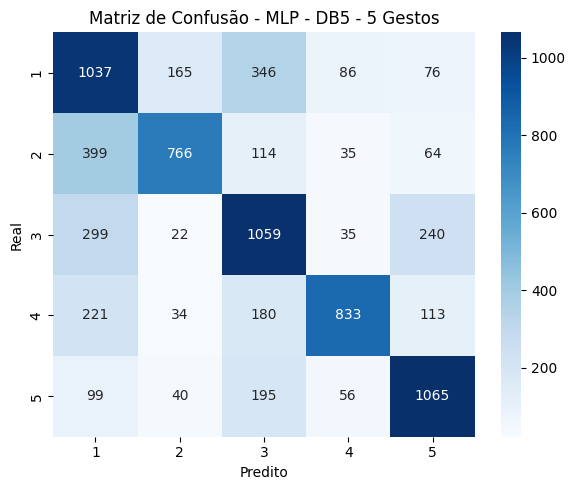

Modelo salvo como 'mlp_db5_5gestos.keras'


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import os


data_path = r"D:\Stash\Datasets\db5_features_3\5g" 
train_file = os.path.join(data_path, "features_train.npz")
test_file = os.path.join(data_path, "features_test.npz")


train_data = np.load(train_file)
test_data = np.load(test_file)
X_train, y_train = train_data["X"], train_data["y"]
X_test, y_test = test_data["X"], test_data["y"]

# Ajuste de labels: de 1-5 para 0-4
y_train -= 1
y_test -= 1


y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)


history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - MLP - DB5 - 5 Gestos")
plt.tight_layout()
plt.show()


model.save("mlp_db5_5gestos.keras")
print("Modelo salvo como 'mlp_db5_5gestos.keras'")


In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ======= FUNÇÃO DO MÓDULO ECA =========
def eca_layer(input_tensor, gamma=2, b=1):
    channels = input_tensor.shape[-1]
    k_size = int(abs((tf.math.log(tf.cast(channels, tf.float32)) / tf.math.log(2.0)) + b) / gamma)
    k_size = k_size if k_size % 2 else k_size + 1

    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    avg_pool = layers.Reshape((channels, 1))(avg_pool)
    conv = layers.Conv1D(1, kernel_size=k_size, padding='same', use_bias=False)(avg_pool)
    conv = layers.Activation("sigmoid")(conv)
    conv = layers.Reshape((1, 1, channels))(conv)

    return layers.Multiply()([input_tensor, conv])

# ======= CARREGAMENTO E PRÉ-PROCESSAMENTO =========
data_dir = r"D:\Stash\Datasets\db5_janelado\5g"

X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []

for i in range(1, 11):
    sujeito = f"S{i}"

    train_path = os.path.join(data_dir, f"{sujeito}_train.npz")
    test_path = os.path.join(data_dir, f"{sujeito}_test.npz")

    if os.path.exists(train_path):
        train_data = np.load(train_path)
        X_train_all.append(train_data["X_train"])
        y_train_all.append(train_data["y_train"])

    if os.path.exists(test_path):
        test_data = np.load(test_path)
        X_test_all.append(test_data["X_test"])
        y_test_all.append(test_data["y_test"])

# Empilhar todos os dados
X_train = np.concatenate(X_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)
X_test = np.concatenate(X_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

# Normalização
X_train = X_train / np.max(np.abs(X_train))
X_test = X_test / np.max(np.abs(X_test))

# Expandir dimensão do canal
X_train = X_train[..., np.newaxis]  # (n, 50, 16, 1)
X_test = X_test[..., np.newaxis]

# Ajustar rótulos e one-hot encoding
y_train -= 1
y_test -= 1
y_train_cat = utils.to_categorical(y_train, num_classes=5)
y_test_cat = utils.to_categorical(y_test, num_classes=5)

# ======= DEFINIÇÃO DO MODELO =========
inputs = layers.Input(shape=(50, 16, 1))

x = layers.Conv2D(32, kernel_size=(5, 1), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 1))(x)
x = eca_layer(x)

x = layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 1))(x)
x = eca_layer(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# ======= TREINAMENTO =========
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# ======= AVALIAÇÃO =========
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - CNN-ECA - DB5 - 5 Gestos")
plt.tight_layout()
plt.show()

# Salvar modelo
model.save("cnn_eca_db5_5g_full.keras")
print("Modelo salvo como 'cnn_eca_db5_5g_full.keras'")


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 50, 16, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 50, 16,    │        192 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 16,    │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 25, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_7[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 32, 1)     │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 32, 1)     │          3 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32, 1)     │          0 │ conv1d_7[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1, 1, 32)  │          0 │ activation_5[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 25, 16,    │          0 │ max_pooling2d_7[… │
│ (Multiply)          │ 32)               │            │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 25, 16,    │      6,208 │ multiply_4[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 16,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 12, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_8[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 64, 1)     │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 64, 1)     │          3 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 64, 1)     │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 793,611 (3.03 MB)

 Trainable params: 793,419 (3.03 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.5591 - loss: 1.1535 - val_accuracy: 0.3110 - val_loss: 1.5332
Epoch 2/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7307 - loss: 0.7090 - val_accuracy: 0.4726 - val_loss: 2.0171
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.7905 - loss: 0.5302 - val_accuracy: 0.4273 - val_loss: 2.4044
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8466 - loss: 0.3992 - val_accuracy: 0.4732 - val_loss: 2.6555
Epoch 5/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8900 - loss: 0.2941 - val_accuracy: 0.4764 - val_loss: 4.7559
Epoch 6/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9138 - loss: 0.2189 - val_accuracy: 0.4589 - val_loss: 3.2018
Epoch 7/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9372 - loss: 0.1653 - val_accuracy: 0.4681 - val_loss: 3.7052
Epoch 8/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9480 - loss: 0.1433 - 

KeyboardInterrupt: 

In [2]:
import os
import numpy as np

data_dir = r"D:\Stash\Datasets\db2_janelado\5g"
output_path = r"D:\Stash\Datasets\db2_janelado\db2_5g_all_data.npz"

def data_generator(data_dir, num_subjects):
    for i in range(1, num_subjects + 1):
        sujeito = f"S{i}"
        print(sujeito)
        train_file = os.path.join(data_dir, f"{sujeito}_train.npz")
        test_file = os.path.join(data_dir, f"{sujeito}_test.npz")

        if os.path.exists(train_file):
            train_data = np.load(train_file)
            yield train_data["X_train"], train_data["y_train"], "train"

        if os.path.exists(test_file):
            test_data = np.load(test_file)
            yield test_data["X_test"], test_data["y_test"], "test"

# Inicializadores
X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []

print("Processando e empilhando os dados...")

for X, y, tipo in data_generator(data_dir, num_subjects=40):
    if tipo == "train":
        X_train_all.append(X)
        y_train_all.append(y)
    else:
        X_test_all.append(X)
        y_test_all.append(y)

# Concatena com menos uso de RAM
X_train = np.concatenate(X_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)
X_test = np.concatenate(X_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

np.savez_compressed(output_path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
print(f"Arquivo salvo em: {output_path}")
print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Processando e empilhando os dados...
S1
S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12
S13
S14
S15
S16
S17
S18
S19
S20
S21
S22
S23
S24
S25
S26
S27
S28
S29
S30
S31
S32
S33
S34
S35
S36
S37
S38
S39
S40
Arquivo salvo em: D:\Stash\Datasets\db2_janelado\db2_5g_all_data.npz
Shapes:
X_train: (71611, 500, 12)
y_train: (71611,)
X_test: (35746, 500, 12)
y_test: (35746,)
